In [23]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("white")

pandas2ri.activate()

In [24]:
# 3005 or 5043
# basin_n = 3005
basin_n = 5043

# full or fullpon
# problem_type = "full"
problem_type = "fullpon"

if basin_n == 3005:
    data_file = "data/data_CHT_SIMPA.txt"
    basin_file = "data/basins_CHT.txt"
elif basin_n == 5043:
    data_file = "data/data_CHG_SIMPA.txt"
    basin_file = "data/basins_CHG.txt"
else:
    raise Exception("Invalid basin.")

In [25]:
# Defining the R script and loading the instance in Python
r = robjects.r
r["source"]("exec_optim_semidist.R")

# Loading the function we have defined in R.
robjects.globalenv["init_global"](data_file, basin_file)
exec_function_r = robjects.globalenv["eval_basin_param"]
get_basin_q = robjects.globalenv["get_basin_q"]

Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
# result_path = "results/final_improve/"
result_path = ""

match (problem_type, basin_n):
    case ("fullpon", 3005):
        exec_types = [
            ("KGE", 1),
            ("MSE", 0),
            ("NSE", 0)
        ]
    case ("full", 3005):
        exec_types = [
            ("NSE", 1),
        ]
    case ("fullpon", 5043):
        exec_types = [
            ("MSE", 0),
            ("NSE", 1),
        ]
    case ("full", 5043):
        exec_types = [
            ("KGE", 1),
            #("MSE", 1),
            ("NSE", 1),
        ]    

result_files = [
    (f"./{result_path}config_{problem_type}_{basin_n}_{model}_{metric}.csv", model, metric) 
    for metric, model in exec_types
]


for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if not os.path.exists(file_name):
        raise Exception("Some files were not found.")

./config_fullpon_5043_0_MSE.csv Yes
./config_fullpon_5043_1_NSE.csv Yes


In [27]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv(basin_file)
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "code", "order", "codedown", "supha", "MSE", "RMSE", "PBIAS", "NSE", "R2", "KGE", "param"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        print(np.loadtxt(file_name, delimiter=",", max_rows=1).shape)
        params = np.loadtxt(file_name, delimiter=",", max_rows=1).reshape([len(basin_df), -1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            basin_order = basin_df["order"][idx]
            codedown = basin_df["codedown"][idx]
            supha = basin_df["supha"][idx]

            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]

            if codedown not in agg_q:
                agg_q[codedown] = 0

            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [model, target, basin_code, basin_order, codedown, supha] + list(metrics) + [param_str]

eval_df = eval_df[eval_df["target"] != "R2"]
eval_df

./config_fullpon_5043_0_MSE.csv Yes
(35,)
./config_fullpon_5043_1_NSE.csv Yes
(35,)


,model,target,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,param
0,0,MSE,5029,1,5043,16168.94,26.118822,5.110658,5.3,0.435971,0.439128,0.534499,[8.81344773e-01;5.27447392e+02;9.49307036e-01;...
1,0,MSE,5054,1,5043,8257.84,5.721184,2.391900,2046.1,-32.513845,0.170920,-19.533513,[7.06590371e-01;2.00000000e+03;9.99771210e-01;...
2,0,MSE,5060,1,5043,15684.26,16.170796,4.021293,164.9,-1.842747,0.364192,-0.696661,[7.14660928e-01;7.32875356e+02;1.00000000e+00;...
3,0,MSE,5071,1,5043,12170.17,10.704491,3.271772,-3.1,0.697094,0.736100,0.632859,[7.80882044e-01;2.00000000e+03;9.98954415e-01;...
4,0,MSE,5043,2,0,277148.04,72.674367,8.524926,-2.8,0.595591,0.603553,0.732309,[1.;491.39328348;0.99973504;99.64569318;0.9993...
5,1,NSE,5029,1,5043,16168.94,18.260757,4.273261,-9.4,0.605664,0.616212,0.651056,[9.48930127e-01;4.59906628e+02;6.40094895e-01;...
6,1,NSE,5054,1,5043,8257.84,0.163094,0.403849,4.1,0.044621,0.058869,-0.158941,[9.46998775e-01;1.98582795e+03;9.99812665e-01;...
7,1,NSE,5060,1,5043,15684.26,1.919475,1.385451,6.1,0.662566,0.694207,0.619236,[8.39424951e-01;1.06287405e+03;8.59900057e-01;...
8,1,NSE,5071,1,5043,12170.17,13.282336,3.644494,1.9,0.624149,0.636624,0.627625,[5.30016389e-01;1.04649641e+03;8.71261911e-01;...
9,1,NSE,5043,2,0,277148.04,75.386109,8.682517,-2.7,0.580501,0.594304,0.740476,[7.55307727e-01;8.42057391e+02;1.00000000e+00;...


In [28]:
eval_df[eval_df["code"] == basin_n]

,model,target,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,param
4,0,MSE,5043,2,0,277148.04,72.674367,8.524926,-2.8,0.595591,0.603553,0.732309,[1.;491.39328348;0.99973504;99.64569318;0.9993...
9,1,NSE,5043,2,0,277148.04,75.386109,8.682517,-2.7,0.580501,0.594304,0.740476,[7.55307727e-01;8.42057391e+02;1.00000000e+00;...


In [29]:
eval_df

,model,target,code,order,codedown,supha,MSE,RMSE,PBIAS,NSE,R2,KGE,param
0,0,MSE,5029,1,5043,16168.94,26.118822,5.110658,5.3,0.435971,0.439128,0.534499,[8.81344773e-01;5.27447392e+02;9.49307036e-01;...
1,0,MSE,5054,1,5043,8257.84,5.721184,2.391900,2046.1,-32.513845,0.170920,-19.533513,[7.06590371e-01;2.00000000e+03;9.99771210e-01;...
2,0,MSE,5060,1,5043,15684.26,16.170796,4.021293,164.9,-1.842747,0.364192,-0.696661,[7.14660928e-01;7.32875356e+02;1.00000000e+00;...
3,0,MSE,5071,1,5043,12170.17,10.704491,3.271772,-3.1,0.697094,0.736100,0.632859,[7.80882044e-01;2.00000000e+03;9.98954415e-01;...
4,0,MSE,5043,2,0,277148.04,72.674367,8.524926,-2.8,0.595591,0.603553,0.732309,[1.;491.39328348;0.99973504;99.64569318;0.9993...
5,1,NSE,5029,1,5043,16168.94,18.260757,4.273261,-9.4,0.605664,0.616212,0.651056,[9.48930127e-01;4.59906628e+02;6.40094895e-01;...
6,1,NSE,5054,1,5043,8257.84,0.163094,0.403849,4.1,0.044621,0.058869,-0.158941,[9.46998775e-01;1.98582795e+03;9.99812665e-01;...
7,1,NSE,5060,1,5043,15684.26,1.919475,1.385451,6.1,0.662566,0.694207,0.619236,[8.39424951e-01;1.06287405e+03;8.59900057e-01;...
8,1,NSE,5071,1,5043,12170.17,13.282336,3.644494,1.9,0.624149,0.636624,0.627625,[5.30016389e-01;1.04649641e+03;8.71261911e-01;...
9,1,NSE,5043,2,0,277148.04,75.386109,8.682517,-2.7,0.580501,0.594304,0.740476,[7.55307727e-01;8.42057391e+02;1.00000000e+00;...


In [30]:
columns = ["model","target","code","order","codedown","supha","MSE","RMSE","PBIAS","NSE","R2","KGE","f0","param"]
display(list(eval_df.columns))
display([(i, i in eval_df.columns) for i in columns])

['model',
 'target',
 'code',
 'order',
 'codedown',
 'supha',
 'MSE',
 'RMSE',
 'PBIAS',
 'NSE',
 'R2',
 'KGE',
 'param']

[('model', True),
 ('target', True),
 ('code', True),
 ('order', True),
 ('codedown', True),
 ('supha', True),
 ('MSE', True),
 ('RMSE', True),
 ('PBIAS', True),
 ('NSE', True),
 ('R2', True),
 ('KGE', True),
 ('f0', False),
 ('param', True)]

In [31]:
eval_df["f0"] = -100
eval_df.loc[:, "param"] = eval_df.loc[:, "param"].str.replace("[", "")
eval_df.loc[:, "param"] = eval_df.loc[:, "param"].str.replace("]", "")
eval_df = eval_df[columns]

In [32]:
eval_df.to_csv(f"table_{problem_type}_{basin_n}.txt", index=False, quoting=csv.QUOTE_NONE)
print(f"{problem_type}_{basin_n}_table.txt")
# eval_df.to_csv(f"fullpon_3005_table.txt", index=False, quoting=csv.QUOTE_NONE)

fullpon_5043_table.txt


/home/eugenio/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/eugenio/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/eugenio/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1852525/1262954819.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2)
/home/eugenio/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

ValueError: min() arg is an empty sequence

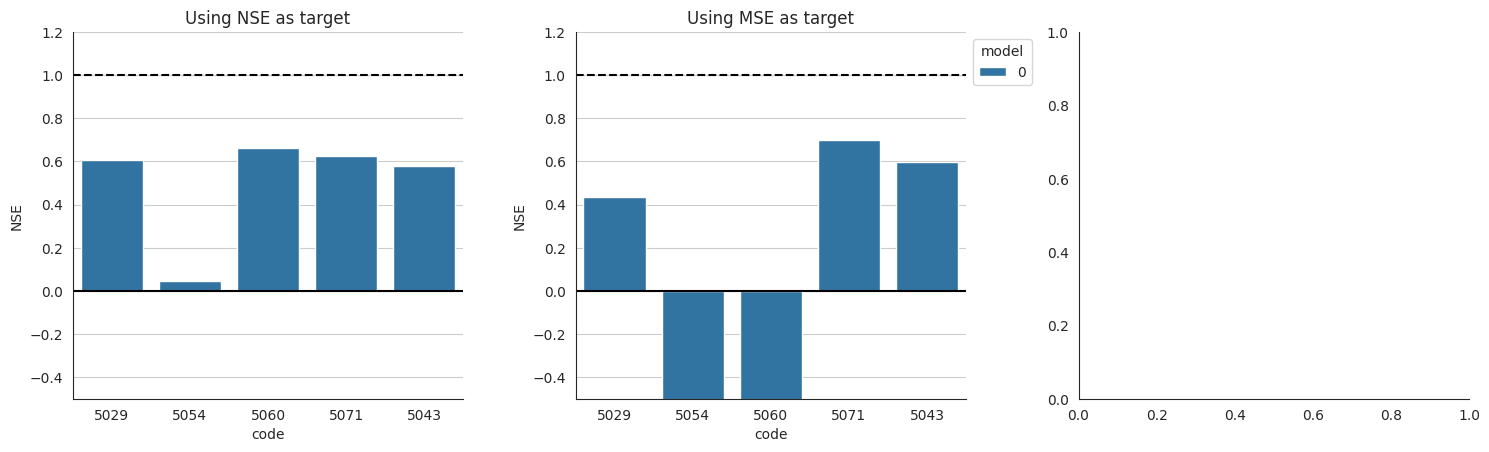

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


metric_measure = "NSE"
for idx, metric in enumerate(["NSE", "MSE", "KGE"]):
    # ax = axes[idx//2, idx%2]
    ax = axes[idx]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][["code", "model", metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="code", y=metric_measure, hue="model", ax=ax, order=basin_df["code"])
    hist_ax.set(title=f"Using {metric} as target")

    if idx == 1:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim=[-0.5, 1.2])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim=[-0.5, 1.2])
            ax.axhline(0, color="k")

    if metric_measure == "Pbias":
        hist_ax.set(ylim=[-150, 750])  # , yticks = range(-25,30,5))
        ax.axhline(0, color="k")

    sns.despine()
    ax.grid(axis="y")

plt.show()